In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from imblearn.over_sampling import SMOTE
from scipy.stats import uniform, randint

In [3]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

In [4]:
print("\nLoading datasets...")
try:
    df_beneficiary = pd.read_csv('/content/drive/MyDrive/Sagility Data Scientist/Train_Beneficiarydata-1542865627584.csv')
    df_inpatient = pd.read_csv('/content/drive/MyDrive/Sagility Data Scientist/Train_Inpatientdata-1542865627584.csv')
    df_outpatient = pd.read_csv('/content/drive/MyDrive/Sagility Data Scientist/Train_Outpatientdata-1542865627584.csv')
    df_train_fraud = pd.read_csv('/content/drive/MyDrive/Sagility Data Scientist/Train-1542865627584.csv')
    print("Datasets loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading file: {e}. Make sure the CSV files are in the correct directory.")

    exit()


Loading datasets...
Datasets loaded successfully.


In [5]:
df_beneficiary['DOB'] = pd.to_datetime(df_beneficiary['DOB'], errors='coerce')
df_beneficiary['DOD'] = pd.to_datetime(df_beneficiary['DOD'], errors='coerce')

In [6]:
reference_date = pd.to_datetime('2009-12-31') # Assuming this is the latest relevant date in the training set
df_beneficiary['Age'] = (reference_date - df_beneficiary['DOB']).dt.days / 365.25
df_beneficiary['Age_at_Death'] = (df_beneficiary['DOD'] - df_beneficiary['DOB']).dt.days / 365.25
df_beneficiary['Age'] = df_beneficiary['Age_at_Death'].fillna(df_beneficiary['Age'])


In [7]:
df_beneficiary['RenalDiseaseIndicator'] = df_beneficiary['RenalDiseaseIndicator'].apply(lambda x: 1 if x == 'Y' else 0)


In [8]:
chronic_cols = [col for col in df_beneficiary.columns if 'ChronicCond_' in col]
for col in chronic_cols:
    df_beneficiary[col] = df_beneficiary[col].map({1: 1, 2: 0})
print("df_beneficiary processed.")

df_beneficiary processed.


In [57]:
df_beneficiary

,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,Age,Age_at_Death
0,BENE11001,1943-01-01,NaT,1,1,0,39,230,12,12,1,0,1,0,0,1,1,1,0,1,1,36000,3204,60,70,66.997947,NaN
1,BENE11002,1936-09-01,NaT,2,1,0,39,280,12,12,0,0,0,0,0,0,0,0,0,0,0,0,0,30,50,73.330595,NaN
2,BENE11003,1936-08-01,NaT,1,1,0,52,590,12,12,1,0,0,0,0,0,0,1,0,0,0,0,0,90,40,73.415469,NaN
3,BENE11004,1922-07-01,NaT,1,1,0,39,270,12,12,1,1,0,0,0,0,1,1,1,1,0,0,0,1810,760,87.501711,NaN
4,BENE11005,1935-09-01,NaT,1,1,0,24,680,12,12,0,0,0,0,1,0,1,0,0,0,0,0,0,1790,1200,74.332649,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138551,BENE159194,1939-07-01,NaT,1,1,0,39,140,12,12,1,0,0,0,0,0,0,0,0,0,0,0,0,430,460,70.502396,NaN
138552,BENE159195,1938-12-01,NaT,2,1,0,49,530,12,12,1,0,0,0,0,0,1,0,0,0,0,0,0,880,100,71.082820,NaN
138553,BENE159196,1916-06-01,NaT,2,1,0,6,150,12,12,0,1,1,1,0,1,1,1,0,0,0,2000,1068,3240,1390,93.582478,NaN
138554,BENE159197,1930-01-01,NaT,1,1,0,16,560,12,12,1,1,0,0,0,0,0,1,0,0,0,0,0,2650,10,79.997262,NaN


In [9]:
print("Processing df_inpatient (Date conversion, DeductibleAmtPaid fillna)...")
date_cols_inpatient = ['ClaimStartDt', 'ClaimEndDt', 'AdmissionDt', 'DischargeDt']
for col in date_cols_inpatient:
    df_inpatient[col] = pd.to_datetime(df_inpatient[col], errors='coerce')

Processing df_inpatient (Date conversion, DeductibleAmtPaid fillna)...


In [10]:
df_inpatient['DeductibleAmtPaid'] = df_inpatient['DeductibleAmtPaid'].fillna(0)
print("df_inpatient processed.")

df_inpatient processed.


In [11]:
print("Processing df_outpatient (Date conversion)...")
date_cols_outpatient = ['ClaimStartDt', 'ClaimEndDt']
for col in date_cols_outpatient:
    df_outpatient[col] = pd.to_datetime(df_outpatient[col], errors='coerce')
# 'DeductibleAmtPaid' in outpatient data generally has no missing values, so no specific fillna.
print("df_outpatient processed.")

Processing df_outpatient (Date conversion)...
df_outpatient processed.


In [12]:
df_inpatient['LengthOfStay'] = (df_inpatient['DischargeDt'] - df_inpatient['AdmissionDt']).dt.days
df_inpatient['ClaimDuration'] = (df_inpatient['ClaimEndDt'] - df_inpatient['ClaimStartDt']).dt.days


In [13]:
diag_cols_inpatient = [f'ClmDiagnosisCode_{i}' for i in range(1, 11)]
proc_cols_inpatient = [f'ClmProcedureCode_{i}' for i in range(1, 7)]
df_inpatient['NumDiagnosisCodes'] = df_inpatient[diag_cols_inpatient].count(axis=1)
df_inpatient['NumProcedureCodes'] = df_inpatient[proc_cols_inpatient].count(axis=1)


In [14]:
df_inpatient['HasAttendingPhysician'] = df_inpatient['AttendingPhysician'].notna().astype(int)
df_inpatient['HasOperatingPhysician'] = df_inpatient['OperatingPhysician'].notna().astype(int)
df_inpatient['HasOtherPhysician'] = df_inpatient['OtherPhysician'].notna().astype(int)


In [15]:
df_outpatient['ClaimDuration'] = (df_outpatient['ClaimEndDt'] - df_outpatient['ClaimStartDt']).dt.days


In [16]:
diag_cols_outpatient = [f'ClmDiagnosisCode_{i}' for i in range(1, 11)]
proc_cols_outpatient = [f'ClmProcedureCode_{i}' for i in range(1, 7)]
df_outpatient['NumDiagnosisCodes'] = df_outpatient[diag_cols_outpatient].count(axis=1)
df_outpatient['NumProcedureCodes'] = df_outpatient[proc_cols_outpatient].count(axis=1)


In [17]:
df_outpatient['HasAttendingPhysician'] = df_outpatient['AttendingPhysician'].notna().astype(int)
df_outpatient['HasOperatingPhysician'] = df_outpatient['OperatingPhysician'].notna().astype(int)
df_outpatient['HasOtherPhysician'] = df_outpatient['OtherPhysician'].notna().astype(int)


In [56]:
df_outpatient

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid,ClmAdmitDiagnosisCode,ClaimDuration,NumDiagnosisCodes,NumProcedureCodes,HasAttendingPhysician,HasOperatingPhysician,HasOtherPhysician
0,BENE11002,CLM624349,2009-10-11,2009-10-11,PRV56011,30,PHY326117,NaN,NaN,78943,V5866,V1272,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,56409,0,3,0,1,0,0
1,BENE11003,CLM189947,2009-02-12,2009-02-12,PRV57610,80,PHY362868,NaN,NaN,6115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,79380,0,1,0,1,0,0
2,BENE11003,CLM438021,2009-06-27,2009-06-27,PRV57595,10,PHY328821,NaN,NaN,2723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,1,0,1,0,0
3,BENE11004,CLM121801,2009-01-06,2009-01-06,PRV56011,40,PHY334319,NaN,NaN,71988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,1,0,1,0,0
4,BENE11004,CLM150998,2009-01-22,2009-01-22,PRV56011,200,PHY403831,NaN,NaN,82382,30000,72887,4280,7197,V4577,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,71947,0,6,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517732,BENE159198,CLM510792,2009-08-06,2009-08-06,PRV53699,800,PHY364188,PHY364188,PHY385752,2163,V4575,53190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,3,0,1,1,1
517733,BENE159198,CLM551294,2009-08-29,2009-08-29,PRV53702,400,PHY423019,PHY332284,NaN,07041,5781,25000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,3,0,1,1,0
517734,BENE159198,CLM596444,2009-09-24,2009-09-24,PRV53676,60,PHY361063,NaN,NaN,V570,78079,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,2,0,1,0,0
517735,BENE159198,CLM636992,2009-10-18,2009-10-18,PRV53689,70,PHY403198,NaN,PHY419379,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,0,0,1,0,1


In [18]:
print("\nMerging Beneficiary details with Inpatient and Outpatient Claims...")
bene_cols_to_merge = ['BeneID', 'Age', 'Gender', 'Race', 'RenalDiseaseIndicator'] + chronic_cols



Merging Beneficiary details with Inpatient and Outpatient Claims...


In [19]:
df_inpatient_merged = pd.merge(df_inpatient, df_beneficiary[bene_cols_to_merge], on='BeneID', how='left')
df_outpatient_merged = pd.merge(df_outpatient, df_beneficiary[bene_cols_to_merge], on='BeneID', how='left')
print("Beneficiary details merged with claim data.")


Beneficiary details merged with claim data.


In [55]:
df_outpatient_merged

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid,ClmAdmitDiagnosisCode,ClaimDuration,NumDiagnosisCodes,NumProcedureCodes,HasAttendingPhysician,HasOperatingPhysician,HasOtherPhysician,Age,Gender,Race,RenalDiseaseIndicator,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke
0,BENE11002,CLM624349,2009-10-11,2009-10-11,PRV56011,30,PHY326117,NaN,NaN,78943,V5866,V1272,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,56409,0,3,0,1,0,0,73.330595,2,1,0,0,0,0,0,0,0,0,0,0,0,0
1,BENE11003,CLM189947,2009-02-12,2009-02-12,PRV57610,80,PHY362868,NaN,NaN,6115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,79380,0,1,0,1,0,0,73.415469,1,1,0,1,0,0,0,0,0,0,1,0,0,0
2,BENE11003,CLM438021,2009-06-27,2009-06-27,PRV57595,10,PHY328821,NaN,NaN,2723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,1,0,1,0,0,73.415469,1,1,0,1,0,0,0,0,0,0,1,0,0,0
3,BENE11004,CLM121801,2009-01-06,2009-01-06,PRV56011,40,PHY334319,NaN,NaN,71988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,1,0,1,0,0,87.501711,1,1,0,1,1,0,0,0,0,1,1,1,1,0
4,BENE11004,CLM150998,2009-01-22,2009-01-22,PRV56011,200,PHY403831,NaN,NaN,82382,30000,72887,4280,7197,V4577,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,71947,0,6,0,1,0,0,87.501711,1,1,0,1,1,0,0,0,0,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517732,BENE159198,CLM510792,2009-08-06,2009-08-06,PRV53699,800,PHY364188,PHY364188,PHY385752,2163,V4575,53190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,3,0,1,1,1,57.749487,2,1,0,1,1,0,0,0,1,1,0,0,1,0
517733,BENE159198,CLM551294,2009-08-29,2009-08-29,PRV53702,400,PHY423019,PHY332284,NaN,07041,5781,25000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,3,0,1,1,0,57.749487,2,1,0,1,1,0,0,0,1,1,0,0,1,0
517734,BENE159198,CLM596444,2009-09-24,2009-09-24,PRV53676,60,PHY361063,NaN,NaN,V570,78079,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,2,0,1,0,0,57.749487,2,1,0,1,1,0,0,0,1,1,0,0,1,0
517735,BENE159198,CLM636992,2009-10-18,2009-10-18,PRV53689,70,PHY403198,NaN,PHY419379,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,0,0,1,0,1,57.749487,2,1,0,1,1,0,0,0,1,1,0,0,1,0


In [20]:
print("\nAggregating Inpatient Data to Provider Level...")
inpatient_agg = {
    'ClaimID': 'count',
    'InscClaimAmtReimbursed': ['sum', 'mean', 'min', 'max', 'std'],
    'DeductibleAmtPaid': ['sum', 'mean'],
    'LengthOfStay': ['mean', 'max'],
    'ClaimDuration': ['mean', 'max'],
    'NumDiagnosisCodes': ['mean', 'max'],
    'NumProcedureCodes': ['mean', 'max'],
    'BeneID': 'nunique',
    'AttendingPhysician': 'nunique',
    'OperatingPhysician': 'nunique',
    'OtherPhysician': 'nunique',
    'HasAttendingPhysician': 'mean',
    'HasOperatingPhysician': 'mean',
    'HasOtherPhysician': 'mean',
    'Age': ['mean', 'std'],
    'Gender': lambda x: x.mode()[0] if not x.empty else np.nan,
    'Race': lambda x: x.mode()[0] if not x.empty else np.nan,
    'RenalDiseaseIndicator': 'mean'
}


Aggregating Inpatient Data to Provider Level...


In [21]:
for col in chronic_cols: # Add chronic condition means
    inpatient_agg[col] = 'mean'

In [22]:
inpatient_provider_agg = df_inpatient_merged.groupby('Provider').agg(inpatient_agg)
inpatient_provider_agg.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in inpatient_provider_agg.columns.values]
inpatient_provider_agg = inpatient_provider_agg.add_prefix('Inpatient_')
inpatient_provider_agg.rename(columns={'Inpatient_ClaimID_count': 'Inpatient_TotalClaims'}, inplace=True)
print("Inpatient data aggregated to provider level.")


Inpatient data aggregated to provider level.


In [54]:
inpatient_provider_agg

,Inpatient_TotalClaims,Inpatient_InscClaimAmtReimbursed_sum,Inpatient_InscClaimAmtReimbursed_mean,Inpatient_InscClaimAmtReimbursed_min,Inpatient_InscClaimAmtReimbursed_max,Inpatient_InscClaimAmtReimbursed_std,Inpatient_DeductibleAmtPaid_sum,Inpatient_DeductibleAmtPaid_mean,Inpatient_LengthOfStay_mean,Inpatient_LengthOfStay_max,Inpatient_ClaimDuration_mean,Inpatient_ClaimDuration_max,Inpatient_NumDiagnosisCodes_mean,Inpatient_NumDiagnosisCodes_max,Inpatient_NumProcedureCodes_mean,Inpatient_NumProcedureCodes_max,Inpatient_BeneID_nunique,Inpatient_AttendingPhysician_nunique,Inpatient_OperatingPhysician_nunique,Inpatient_OtherPhysician_nunique,Inpatient_HasAttendingPhysician_mean,Inpatient_HasOperatingPhysician_mean,Inpatient_HasOtherPhysician_mean,Inpatient_Age_mean,Inpatient_Age_std,Inpatient_Gender_<lambda>,Inpatient_Race_<lambda>,Inpatient_RenalDiseaseIndicator_mean,Inpatient_ChronicCond_Alzheimer_mean,Inpatient_ChronicCond_Heartfailure_mean,Inpatient_ChronicCond_KidneyDisease_mean,Inpatient_ChronicCond_Cancer_mean,Inpatient_ChronicCond_ObstrPulmonary_mean,Inpatient_ChronicCond_Depression_mean,Inpatient_ChronicCond_Diabetes_mean,Inpatient_ChronicCond_IschemicHeart_mean,Inpatient_ChronicCond_Osteoporasis_mean,Inpatient_ChronicCond_rheumatoidarthritis_mean,Inpatient_ChronicCond_stroke_mean
Provider,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
PRV51001,5,97000,19400.000000,3000,42000,18352.111595,5340.0,1068.000000,5.000000,14,5.000000,14,7.200000,9,0.600000,2,5,4,2,1,1.0,0.400000,0.200000,78.565914,10.717805,2,1,0.400000,0.400000,0.800000,0.800000,0.200000,0.400000,0.800000,0.800000,0.800000,0.000000,0.600000,0.400000
PRV51003,62,573000,9241.935484,0,57000,8513.606244,66216.0,1068.000000,5.161290,27,5.161290,27,8.112903,10,0.774194,2,53,2,2,0,1.0,0.645161,0.000000,70.886092,14.394925,2,1,0.274194,0.516129,0.580645,0.629032,0.112903,0.370968,0.403226,0.790323,0.887097,0.209677,0.306452,0.112903
PRV51007,3,19000,6333.333333,3000,10000,3511.884584,3204.0,1068.000000,5.333333,7,5.333333,7,7.333333,9,0.333333,1,3,2,1,0,1.0,0.333333,0.000000,78.832763,4.925589,2,1,0.333333,0.666667,1.000000,0.333333,0.000000,0.000000,0.666667,1.000000,1.000000,0.000000,0.333333,0.666667
PRV51008,2,25000,12500.000000,4000,21000,12020.815280,2136.0,1068.000000,4.000000,5,4.000000,5,7.500000,9,1.000000,1,2,2,2,0,1.0,1.000000,0.000000,51.624914,31.408899,1,1,0.000000,0.500000,0.000000,0.500000,0.500000,0.500000,0.000000,0.500000,1.000000,0.000000,0.000000,0.000000
PRV51011,1,5000,5000.000000,5000,5000,NaN,1068.0,1068.000000,5.000000,5,5.000000,5,8.000000,8,0.000000,0,1,1,0,0,1.0,0.000000,0.000000,97.834360,NaN,2,1,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PRV57719,4,76000,19000.000000,5000,57000,25350.871122,4272.0,1068.000000,13.750000,35,13.750000,35,8.250000,10,0.750000,2,4,4,2,1,1.0,0.500000,0.250000,65.916496,20.928403,1,1,0.250000,0.750000,1.000000,0.500000,0.250000,0.500000,0.750000,1.000000,0.750000,1.000000,0.500000,0.250000
PRV57728,1,6000,6000.000000,6000,6000,NaN,1068.0,1068.000000,4.000000,4,4.000000,4,6.000000,6,0.000000,0,1,1,0,1,1.0,0.000000,1.000000,86.502396,NaN,1,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
PRV57729,11,107000,9727.272727,3000,24000,7226.214903,11748.0,1068.000000,5.545455,15,5.545455,15,8.363636,10,0.545455,1,10,10,5,1,1.0,0.545455,0.090909,74.583038,8.401777,1,1,0.272727,0.909091,0.727273,0.636364,0.272727,0.727273,0.636364,0.909091,0.909091,0.363636,0.363636,0.545455


In [23]:
print("\nAggregating Outpatient Data to Provider Level...")
outpatient_agg = {
    'ClaimID': 'count',
    'InscClaimAmtReimbursed': ['sum', 'mean', 'min', 'max', 'std'],
    'DeductibleAmtPaid': ['sum', 'mean'],
    'ClaimDuration': ['mean', 'max'],
    'NumDiagnosisCodes': ['mean', 'max'],
    'NumProcedureCodes': ['mean', 'max'],
    'BeneID': 'nunique',
    'AttendingPhysician': 'nunique',
    'OperatingPhysician': 'nunique',
    'OtherPhysician': 'nunique',
    'HasAttendingPhysician': 'mean',
    'HasOperatingPhysician': 'mean',
    'HasOtherPhysician': 'mean',
    'Age': ['mean', 'std'],
    'Gender': lambda x: x.mode()[0] if not x.empty else np.nan,
    'Race': lambda x: x.mode()[0] if not x.empty else np.nan,
    'RenalDiseaseIndicator': 'mean'
}


Aggregating Outpatient Data to Provider Level...


In [24]:
for col in chronic_cols:
    outpatient_agg[col] = 'mean'


In [25]:
outpatient_provider_agg = df_outpatient_merged.groupby('Provider').agg(outpatient_agg)
outpatient_provider_agg.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in outpatient_provider_agg.columns.values]
outpatient_provider_agg = outpatient_provider_agg.add_prefix('Outpatient_')
outpatient_provider_agg.rename(columns={'Outpatient_ClaimID_count': 'Outpatient_TotalClaims'}, inplace=True)
print("Outpatient data aggregated to provider level.")

Outpatient data aggregated to provider level.


In [53]:
outpatient_provider_agg

,Outpatient_TotalClaims,Outpatient_InscClaimAmtReimbursed_sum,Outpatient_InscClaimAmtReimbursed_mean,Outpatient_InscClaimAmtReimbursed_min,Outpatient_InscClaimAmtReimbursed_max,Outpatient_InscClaimAmtReimbursed_std,Outpatient_DeductibleAmtPaid_sum,Outpatient_DeductibleAmtPaid_mean,Outpatient_ClaimDuration_mean,Outpatient_ClaimDuration_max,Outpatient_NumDiagnosisCodes_mean,Outpatient_NumDiagnosisCodes_max,Outpatient_NumProcedureCodes_mean,Outpatient_NumProcedureCodes_max,Outpatient_BeneID_nunique,Outpatient_AttendingPhysician_nunique,Outpatient_OperatingPhysician_nunique,Outpatient_OtherPhysician_nunique,Outpatient_HasAttendingPhysician_mean,Outpatient_HasOperatingPhysician_mean,Outpatient_HasOtherPhysician_mean,Outpatient_Age_mean,Outpatient_Age_std,Outpatient_Gender_<lambda>,Outpatient_Race_<lambda>,Outpatient_RenalDiseaseIndicator_mean,Outpatient_ChronicCond_Alzheimer_mean,Outpatient_ChronicCond_Heartfailure_mean,Outpatient_ChronicCond_KidneyDisease_mean,Outpatient_ChronicCond_Cancer_mean,Outpatient_ChronicCond_ObstrPulmonary_mean,Outpatient_ChronicCond_Depression_mean,Outpatient_ChronicCond_Diabetes_mean,Outpatient_ChronicCond_IschemicHeart_mean,Outpatient_ChronicCond_Osteoporasis_mean,Outpatient_ChronicCond_rheumatoidarthritis_mean,Outpatient_ChronicCond_stroke_mean
Provider,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
PRV51001,20,7640,382.000000,10,1500,422.817617,0,0.000000,0.550000,9,2.200000,6,0.0,0,19,10,3,7,1.000000,0.150000,0.450000,78.904038,12.511846,2,1,0.300000,0.650000,0.750000,0.650000,0.200000,0.400000,0.250000,0.850000,0.950000,0.300000,0.250000,0.200000
PRV51003,70,32670,466.714286,0,3300,821.364579,70,1.000000,2.357143,20,2.714286,10,0.0,0,66,44,5,22,1.000000,0.071429,0.357143,69.363684,12.597392,2,1,0.171429,0.342857,0.628571,0.357143,0.042857,0.257143,0.414286,0.728571,0.814286,0.285714,0.271429,0.071429
PRV51004,149,52170,350.134228,0,3300,689.963754,310,2.080537,1.429530,20,2.583893,9,0.0,0,138,38,19,26,1.000000,0.181208,0.422819,72.259857,12.918090,2,1,0.154362,0.429530,0.590604,0.335570,0.107383,0.275168,0.422819,0.704698,0.724832,0.328859,0.308725,0.114094
PRV51005,1165,280910,241.124464,0,4080,491.556392,3700,3.175966,1.088412,20,2.588841,10,0.0,0,495,6,6,4,0.998283,0.190558,0.410300,70.541703,13.352244,2,1,0.222318,0.365665,0.583691,0.435193,0.141631,0.253219,0.416309,0.685837,0.768240,0.295279,0.284120,0.106438
PRV51007,69,14710,213.188406,0,3300,447.231657,60,0.869565,0.768116,20,2.797101,10,0.0,0,56,8,4,7,1.000000,0.159420,0.376812,68.894484,14.783859,2,1,0.144928,0.347826,0.536232,0.304348,0.173913,0.231884,0.391304,0.666667,0.695652,0.304348,0.304348,0.144928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PRV57759,28,10640,380.000000,10,3300,820.880286,130,4.642857,2.142857,20,2.071429,5,0.0,0,24,1,1,1,1.000000,0.035714,0.428571,74.010951,8.859825,1,1,0.178571,0.500000,0.714286,0.535714,0.142857,0.392857,0.321429,0.714286,1.000000,0.464286,0.321429,0.142857
PRV57760,22,4770,216.818182,20,1100,309.998254,0,0.000000,0.318182,7,2.363636,7,0.0,0,9,3,2,2,1.000000,0.272727,0.409091,61.502458,9.792172,1,1,0.000000,0.136364,0.500000,0.090909,0.000000,0.090909,0.318182,0.818182,1.000000,0.500000,0.045455,0.000000
PRV57761,82,18470,225.243902,0,2200,418.366092,370,4.512195,1.390244,20,2.670732,9,0.0,0,67,2,5,2,1.000000,0.170732,0.439024,71.947013,16.544775,2,1,0.280488,0.439024,0.682927,0.487805,0.170732,0.365854,0.463415,0.670732,0.756098,0.390244,0.292683,0.121951


In [27]:
print("\nCombining Inpatient and Outpatient Provider Aggregations...")
provider_features = pd.merge(inpatient_provider_agg, outpatient_provider_agg, on='Provider', how='outer', suffixes=('_Inpatient', '_Outpatient'))
provider_features = provider_features.fillna(0) # Fill NaNs (e.g., provider only has one type of claim)
print("Inpatient and outpatient aggregations combined.")


Combining Inpatient and Outpatient Provider Aggregations...
Inpatient and outpatient aggregations combined.


In [28]:
print("\nGenerating Combined Provider-Level Features...")
provider_features['TotalClaims'] = provider_features['Inpatient_TotalClaims'] + provider_features['Outpatient_TotalClaims']
provider_features['TotalReimbursement'] = provider_features['Inpatient_InscClaimAmtReimbursed_sum'] + provider_features['Outpatient_InscClaimAmtReimbursed_sum']
provider_features['TotalDeductiblePaid'] = provider_features['Inpatient_DeductibleAmtPaid_sum'] + provider_features['Outpatient_DeductibleAmtPaid_sum']



Generating Combined Provider-Level Features...


In [29]:
provider_features['AvgReimbursementPerClaim'] = provider_features['TotalReimbursement'] / provider_features['TotalClaims']
provider_features['AvgReimbursementPerClaim'].fillna(0, inplace=True)


In [30]:
provider_features['TotalUniqueBeneficiaries'] = provider_features['Inpatient_BeneID_nunique'] + provider_features['Outpatient_BeneID_nunique']
provider_features['ClaimsPerBeneficiary'] = provider_features['TotalClaims'] / provider_features['TotalUniqueBeneficiaries']
provider_features['ClaimsPerBeneficiary'].fillna(0, inplace=True)

In [31]:
provider_features['TotalUniqueAttendingPhysicians'] = provider_features['Inpatient_AttendingPhysician_nunique'] + provider_features['Outpatient_AttendingPhysician_nunique']
provider_features['TotalUniqueOperatingPhysicians'] = provider_features['Inpatient_OperatingPhysician_nunique'] + provider_features['Outpatient_OperatingPhysician_nunique']
provider_features['TotalUniqueOtherPhysicians'] = provider_features['Inpatient_OtherPhysician_nunique'] + provider_features['Outpatient_OtherPhysician_nunique']


In [32]:
provider_features['InpatientClaimsRatio'] = provider_features['Inpatient_TotalClaims'] / provider_features['TotalClaims']
provider_features['InpatientClaimsRatio'].fillna(0, inplace=True)


/tmp/ipython-input-32-819488305.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  provider_features['InpatientClaimsRatio'].fillna(0, inplace=True)


In [33]:
provider_features['InpatientReimbursementRatio'] = provider_features['Inpatient_InscClaimAmtReimbursed_sum'] / provider_features['TotalReimbursement']
provider_features['InpatientReimbursementRatio'].fillna(0, inplace=True)


In [34]:
provider_features['AvgHasOperatingPhysician'] = (
    provider_features['Inpatient_HasOperatingPhysician_mean'] * provider_features['Inpatient_TotalClaims'] +
    provider_features['Outpatient_HasOperatingPhysician_mean'] * provider_features['Outpatient_TotalClaims']
) / provider_features['TotalClaims']
provider_features['AvgHasOperatingPhysician'].fillna(0, inplace=True)

/tmp/ipython-input-34-1096368781.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  provider_features['AvgHasOperatingPhysician'].fillna(0, inplace=True)


In [35]:
provider_features['AvgHasOtherPhysician'] = (
    provider_features['Inpatient_HasOtherPhysician_mean'] * provider_features['Inpatient_TotalClaims'] +
    provider_features['Outpatient_HasOtherPhysician_mean'] * provider_features['Outpatient_TotalClaims']
) / provider_features['TotalClaims']
provider_features['AvgHasOtherPhysician'].fillna(0, inplace=True)
print("Combined provider-level features generated.")

Combined provider-level features generated.


In [36]:
provider_features

,Inpatient_TotalClaims,Inpatient_InscClaimAmtReimbursed_sum,Inpatient_InscClaimAmtReimbursed_mean,Inpatient_InscClaimAmtReimbursed_min,Inpatient_InscClaimAmtReimbursed_max,Inpatient_InscClaimAmtReimbursed_std,Inpatient_DeductibleAmtPaid_sum,Inpatient_DeductibleAmtPaid_mean,Inpatient_LengthOfStay_mean,Inpatient_LengthOfStay_max,Inpatient_ClaimDuration_mean,Inpatient_ClaimDuration_max,Inpatient_NumDiagnosisCodes_mean,Inpatient_NumDiagnosisCodes_max,Inpatient_NumProcedureCodes_mean,Inpatient_NumProcedureCodes_max,Inpatient_BeneID_nunique,Inpatient_AttendingPhysician_nunique,Inpatient_OperatingPhysician_nunique,Inpatient_OtherPhysician_nunique,Inpatient_HasAttendingPhysician_mean,Inpatient_HasOperatingPhysician_mean,Inpatient_HasOtherPhysician_mean,Inpatient_Age_mean,Inpatient_Age_std,Inpatient_Gender_<lambda>,Inpatient_Race_<lambda>,Inpatient_RenalDiseaseIndicator_mean,Inpatient_ChronicCond_Alzheimer_mean,Inpatient_ChronicCond_Heartfailure_mean,Inpatient_ChronicCond_KidneyDisease_mean,Inpatient_ChronicCond_Cancer_mean,Inpatient_ChronicCond_ObstrPulmonary_mean,Inpatient_ChronicCond_Depression_mean,Inpatient_ChronicCond_Diabetes_mean,Inpatient_ChronicCond_IschemicHeart_mean,Inpatient_ChronicCond_Osteoporasis_mean,Inpatient_ChronicCond_rheumatoidarthritis_mean,Inpatient_ChronicCond_stroke_mean,Outpatient_TotalClaims,Outpatient_InscClaimAmtReimbursed_sum,Outpatient_InscClaimAmtReimbursed_mean,Outpatient_InscClaimAmtReimbursed_min,Outpatient_InscClaimAmtReimbursed_max,Outpatient_InscClaimAmtReimbursed_std,Outpatient_DeductibleAmtPaid_sum,Outpatient_DeductibleAmtPaid_mean,Outpatient_ClaimDuration_mean,Outpatient_ClaimDuration_max,Outpatient_NumDiagnosisCodes_mean,Outpatient_NumDiagnosisCodes_max,Outpatient_NumProcedureCodes_mean,Outpatient_NumProcedureCodes_max,Outpatient_BeneID_nunique,Outpatient_AttendingPhysician_nunique,Outpatient_OperatingPhysician_nunique,Outpatient_OtherPhysician_nunique,Outpatient_HasAttendingPhysician_mean,Outpatient_HasOperatingPhysician_mean,Outpatient_HasOtherPhysician_mean,Outpatient_Age_mean,Outpatient_Age_std,Outpatient_Gender_<lambda>,Outpatient_Race_<lambda>,Outpatient_RenalDiseaseIndicator_mean,Outpatient_ChronicCond_Alzheimer_mean,Outpatient_ChronicCond_Heartfailure_mean,Outpatient_ChronicCond_KidneyDisease_mean,Outpatient_ChronicCond_Cancer_mean,Outpatient_ChronicCond_ObstrPulmonary_mean,Outpatient_ChronicCond_Depression_mean,Outpatient_ChronicCond_Diabetes_mean,Outpatient_ChronicCond_IschemicHeart_mean,Outpatient_ChronicCond_Osteoporasis_mean,Outpatient_ChronicCond_rheumatoidarthritis_mean,Outpatient_ChronicCond_stroke_mean,TotalClaims,TotalReimbursement,TotalDeductiblePaid,AvgReimbursementPerClaim,TotalUniqueBeneficiaries,ClaimsPerBeneficiary,TotalUniqueAttendingPhysicians,TotalUniqueOperatingPhysicians,TotalUniqueOtherPhysicians,InpatientClaimsRatio,InpatientReimbursementRatio,AvgHasOperatingPhysician,AvgHasOtherPhysician
Provider,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
PRV51001,5.0,97000.0,19400.000000,3000.0,42000.0,18352.111595,5340.0,1068.0,5.000000,14.0,5.000000,14.0,7.200000,9.0,0.600000,2.0,5.0,4.0,2.0,1.0,1.0,0.400000,0.2,78.565914,10.717805,2.0,1.0,0.400000,0.400000,0.800000,0.800000,0.200000,0.400000,0.800000,0.800000,0.800000,0.000000,0.600000,0.400000,20.0,7640.0,382.000000,10.0,1500.0,422.817617,0.0,0.000000,0.550000,9.0,2.200000,6.0,0.0,0.0,19.0,10.0,3.0,7.0,1.000000,0.150000,0.450000,78.904038,12.511846,2.0,1.0,0.300000,0.650000,0.750000,0.650000,0.200000,0.400000,0.250000,0.850000,0.950000,0.300000,0.250000,0.200000,25.0,104640.0,5340.0,4185.600000,24.0,1.041667,14.0,5.0,8.0,0.200000,0.926988,0.200000,0.400000
PRV51003,62.0,573000.0,9241.935484,0.0,57000.0,8513.606244,66216.0,1068.0,5.161290,27.0,5.161290,27.0,8.112903,10.0,0.774194,2.0,53.0,2.0,2.0,0.0,1.0,0.645161,0.0,70.886092,14.394925,2.0,1.0,0.274194,0.516129,0.580645,0.629032,0.112903,0.370968,0.403226,0.790323,0.887097,0.209677,0.306452,0.112903,70.0,32670.0,466.714286,0.0,3

In [37]:
print("\n--- Merging with Target Variable and Finalizing DataFrame ---")
final_df = pd.merge(df_train_fraud, provider_features, on='Provider', how='left')
final_df['PotentialFraud'] = final_df['PotentialFraud'].map({'Yes': 1, 'No': 0}) # Convert 'Yes'/'No' to 1/0
print("Target variable merged and converted. Feature Engineering complete.")



--- Merging with Target Variable and Finalizing DataFrame ---
Target variable merged and converted. Feature Engineering complete.


In [38]:
X = final_df.drop(['Provider', 'PotentialFraud'], axis=1)
y = final_df['PotentialFraud']

In [39]:
categorical_features = [col for col in X.columns if 'Gender_<lambda>' in col or 'Race_<lambda>' in col]
numerical_features = X.columns.drop(categorical_features).tolist()

print(f"Identified {len(numerical_features)} numerical features and {len(categorical_features)} categorical features.")


Identified 85 numerical features and 4 categorical features.


In [40]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)
print("Data preprocessing pipeline created.")

Data preprocessing pipeline created.


In [41]:
print("\n--- 4. Splitting Data into Training and Validation Sets ---")

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Original training set size: {X_train.shape[0]} samples (Fraud Ratio: {y_train.sum() / len(y_train):.4f})")
print(f"Validation set size: {X_val.shape[0]} samples (Fraud Ratio: {y_val.sum() / len(y_val):.4f})")


--- 4. Splitting Data into Training and Validation Sets ---
Original training set size: 4328 samples (Fraud Ratio: 0.0936)
Validation set size: 1082 samples (Fraud Ratio: 0.0933)


In [42]:
smote = SMOTE(random_state=42)

In [43]:
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)

In [44]:
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

print(f"Resampled training samples after SMOTE: {X_train_resampled.shape[0]} samples (Fraud Ratio: {y_train_resampled.sum() / len(y_train_resampled):.4f})")

Resampled training samples after SMOTE: 7846 samples (Fraud Ratio: 0.5000)
SMOTE applied to training data.


In [48]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42, solver='liblinear'),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

In [49]:
param_distributions = {
    'Logistic Regression': {
        'C': uniform(loc=0, scale=4),
        'penalty': ['l1', 'l2']
    },
    'XGBoost': {
        'n_estimators': randint(50, 200),
        'learning_rate': uniform(loc=0.01, scale=0.3),
        'max_depth': randint(3, 10),
        'subsample': uniform(loc=0.6, scale=0.4),
        'colsample_bytree': uniform(loc=0.6, scale=0.4)
            }
}

In [50]:
best_models = {}
for name, model in models.items():
    print(f"\n--- Tuning {name} ---")
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_distributions[name],
        n_iter=50,
        cv=5,
        scoring='roc_auc',
        random_state=42,
        n_jobs=-1,
        verbose=1
    )
    search.fit(X_train_resampled, y_train_resampled)
    best_models[name] = search.best_estimator_
    print(f"Best parameters for {name}: {search.best_params_}")
    print(f"Best ROC-AUC score on training (after CV) for {name}: {search.best_score_:.4f}")


--- Tuning Logistic Regression ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters for Logistic Regression: {'C': np.float64(3.8446880973973965), 'penalty': 'l1'}
Best ROC-AUC score on training (after CV) for Logistic Regression: 0.9590

--- Tuning XGBoost ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:20:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters for XGBoost: {'colsample_bytree': np.float64(0.7015661655737379), 'learning_rate': np.float64(0.08406281885158035), 'max_depth': 9, 'n_estimators': 179, 'subsample': np.float64(0.8849082359697769)}
Best ROC-AUC score on training (after CV) for XGBoost: 0.9970



--- Evaluation for Logistic Regression ---
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.90      0.94       981
           1       0.49      0.89      0.63       101

    accuracy                           0.90      1082
   macro avg       0.74      0.90      0.79      1082
weighted avg       0.94      0.90      0.91      1082

Confusion Matrix:
|                 | Predicted No Fraud   | Predicted Fraud   |
|:----------------|:---------------------|:------------------|
| Actual No Fraud | 887                  | 94                |
| Actual Fraud    | 11                   | 90                |
ROC-AUC Score: 0.9606

--- Evaluation for XGBoost ---
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       981
           1       0.70      0.75      0.73       101

    accuracy                           0.95      1082
   macro avg       0.84      0.86      0.

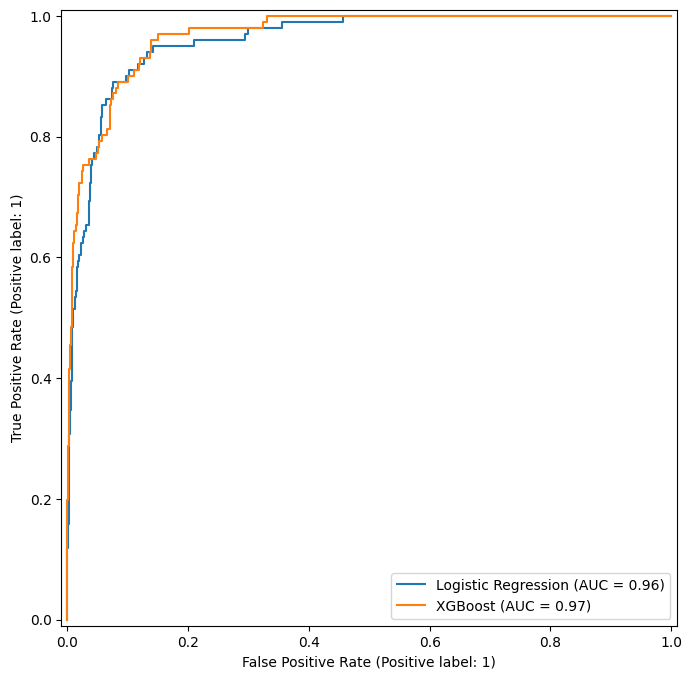

In [51]:
plt.figure(figsize=(10, 8))
ax = plt.gca()

for name, model in best_models.items():
    print(f"\n--- Evaluation for {name} ---")


    y_pred = model.predict(X_val_processed)
    y_proba = model.predict_proba(X_val_processed)[:, 1]


    print("Classification Report:")
    print(classification_report(y_val, y_pred))

    # Print Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)
    print("Confusion Matrix:")
    cm_df = pd.DataFrame(cm, index=['Actual No Fraud', 'Actual Fraud'], columns=['Predicted No Fraud', 'Predicted Fraud'])
    print(cm_df.to_markdown(numalign="left", stralign="left"))


    # Calculate and print ROC-AUC Score
    roc_auc = roc_auc_score(y_val, y_proba)
    print(f"ROC-AUC Score: {roc_auc:.4f}")
    RocCurveDisplay.from_estimator(model, X_val_processed, y_val, name=name, ax=ax)


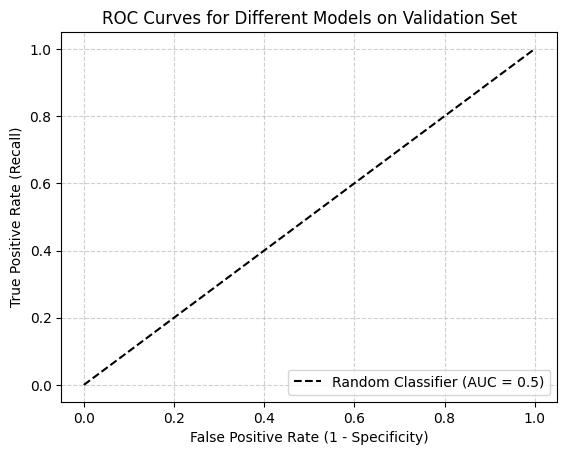

In [52]:
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.5)')
plt.title('ROC Curves for Different Models on Validation Set')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Recall)')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()